Majority of the code used in this file is from both the workbook session in class as well as the WB_Apriori_PA01.ipynb file supplied in canvas

In [30]:
import pandas as pd
import random
from itertools import combinations
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings("ignore")

In [31]:
transaction_data = pd.read_excel("electronics_sales_PA01.xlsx")
transaction_data

,Transaction ID,Items Purchased
0,1,"['Camera', 'Headphones', 'Laptop', 'Smartwatch..."
1,2,"['Laptop', 'Tablet', 'Camera', 'Printer', 'Hea..."
2,3,['Tablet']
3,4,"['Laptop', 'Printer', 'Tablet', 'Smartwatch', ..."
4,5,"['Headphones', 'Laptop', 'Smartwatch', 'Printe..."
5,6,['Laptop']
6,7,"['Printer', 'Headphones']"
7,8,"['Camera', 'Smartphone', 'Laptop', 'Headphones']"
8,9,"['Tablet', 'Smartphone', 'Smartwatch', 'Camera..."
9,10,"['Camera', 'Smartwatch', 'Headphones', 'Tablet..."


In [32]:
# split the csv into a list
transaction_data['Items Purchased'] = transaction_data['Items Purchased'].apply(lambda x:x.replace("[", "").replace("]", "").replace("\'", "").replace(" ", "").split(',')) # Format data due to xlsx table providing data as a python list instead of comma seperated values
transaction_data

,Transaction ID,Items Purchased
0,1,"[Camera, Headphones, Laptop, Smartwatch, Smart..."
1,2,"[Laptop, Tablet, Camera, Printer, Headphones, ..."
2,3,[Tablet]
3,4,"[Laptop, Printer, Tablet, Smartwatch, Camera]"
4,5,"[Headphones, Laptop, Smartwatch, Printer, Tablet]"
5,6,[Laptop]
6,7,"[Printer, Headphones]"
7,8,"[Camera, Smartphone, Laptop, Headphones]"
8,9,"[Tablet, Smartphone, Smartwatch, Camera, Lapto..."
9,10,"[Camera, Smartwatch, Headphones, Tablet, Laptop]"


In [33]:
# get the list of unique items in the entire list
all_items = sorted(set(item for subset in transaction_data['Items Purchased'] for item in subset))
all_items

['Camera',
 'Headphones',
 'Laptop',
 'Printer',
 'Smartphone',
 'Smartwatch',
 'Tablet']

In [34]:
# creating an DataFrame for one hot encoding with all zeros
one_hot_endcoded_data = pd.DataFrame(0, index = transaction_data['Transaction ID'], columns = all_items)
#one_hot_endcoded_data

In [35]:
for index, row in transaction_data.iterrows():
    for item in row['Items Purchased']:
        one_hot_endcoded_data.at[row['Transaction ID'], item] = 1

# one_hot_endcoded_data

1. Part A (50 Points)
Task:
Manually apply the Apriori Algorithm to generate frequent itemsets for the following minimum
support values: 3, 4, and 5. Present your results in terms of C-tables (candidate itemsets) and L-
tables (frequent itemsets).

In [36]:
# Assign the one-hot encoded DataFrame (where each column represents an item and each row a transaction) to df
data = one_hot_endcoded_data

# Set the minimum support count threshold. In this case, an itemset must appear in at least 2 transactions to be considered frequent
min_sup_count = 3

def get_support_count(data, itemset):
    """ 
    Function to calculate the support count of a given itemset (number of transactions in which the itemset appears).
    
    Parameters:
    df: The DataFrame where each row represents a transaction and each column represents an item (1 if present, 0 if absent).
    itemset: A tuple of items to check support for.
    
    Returns:
    The support count of the given itemset (how many transactions contain all items in the itemset).
    """
    # Create a boolean mask that checks if all items in the itemset have a value of 1 (present) in each transaction
    mask = data[list(itemset)].all(axis=1)
    # Sum the mask (True = 1, False = 0) to count how many transactions contain the itemset
    return mask.sum()

def apriori_incremental(data, min_sup_count):
    """ 
    Function to generate frequent itemsets using an incremental approach (the Apriori algorithm).
    
    Parameters:
    df: The DataFrame where each row represents a transaction, and each column represents an item (1 if present, 0 if absent).
    min_sup_count: The minimum support count required for an itemset to be considered frequent.
    
    This function generates and displays all frequent itemsets incrementally, starting with single items and then moving to pairs, triples, etc.
    """
    # Extract the column names from the DataFrame (each column represents an item)
    items = data.columns
    # Initialize k to represent the size of the itemsets (starting with k=1 for single items)
    k = 1
    # Initialize an empty list to store frequent itemsets at each level
    frequent_itemsets = []
    all_frequent_itemsets = []

    # Loop indefinitely until no more frequent itemsets are found
    while True:
        if k == 1:
            # For k = 1, generate 1-frequent itemsets, which are just individual items
            candidates = [(item,) for item in items]
        else:
            # For k > 1, generate k-frequent itemsets by combining the items from the previous level
            # It does this by combining all previous frequent itemsets (flattening them and taking combinations of k items)
            candidates = list(combinations(set(i for subset in frequent_itemsets for i in subset), k))

        # Initialize lists to store all itemsets and their support counts for this level
        all_itemsets = []
        itemset_support = []
        
        # Loop through each candidate itemset and calculate its support count
        for itemset in candidates:
            # Sort and convert the itemset to a tuple to ensure consistent ordering and to avoid duplicates
            itemset = tuple(sorted(set(itemset)))
            # Get the support count for the current itemset by calling the get_support_count function
            support_count = get_support_count(data, itemset)
            # Store the itemset along with its support count
            all_itemsets.append((itemset, support_count))

        # Display all k-frequent itemsets before filtering by the minimum support count
        print(f"\n{k}-frequent itemsets (before filtering by min_sup_count):")
        for itemset, support_count in all_itemsets:
            print(f"Itemset: {itemset}, Support Count: {support_count}")

        # Filter the itemsets, keeping only those that meet or exceed the minimum support count
        valid_itemsets = [(itemset, support_count) for itemset, support_count in all_itemsets if support_count >= min_sup_count]

        # If there are no valid itemsets left (none meet the support threshold), break out of the loop
        if not valid_itemsets:
            break

        # Display the filtered frequent itemsets and their support counts
        print(f"\n{k}-frequent itemsets (after filtering by min_sup_count):")
        for itemset, support_count in valid_itemsets:
            print(f"Itemset: {itemset}, Support Count: {support_count}")
        
        # Update the frequent itemsets list with the valid itemsets for the next iteration
        frequent_itemsets = [itemset for itemset, support_count in valid_itemsets]
        # Increment k to move to the next level of itemsets (e.g., from pairs to triples)
        k += 1

        # Add all frequent itemsets and support count to running list
        all_frequent_itemsets.extend([(itemset, support) for itemset, support in valid_itemsets])
        
    return all_frequent_itemsets
        

# Call the apriori_incremental function to run the Apriori algorithm and find frequent itemsets
all_frequent_itemsets = apriori_incremental(data, min_sup_count)
all_frequent_itemsets



1-frequent itemsets (before filtering by min_sup_count):
Itemset: ('Camera',), Support Count: 7
Itemset: ('Headphones',), Support Count: 8
Itemset: ('Laptop',), Support Count: 9
Itemset: ('Printer',), Support Count: 7
Itemset: ('Smartphone',), Support Count: 5
Itemset: ('Smartwatch',), Support Count: 6
Itemset: ('Tablet',), Support Count: 7

1-frequent itemsets (after filtering by min_sup_count):
Itemset: ('Camera',), Support Count: 7
Itemset: ('Headphones',), Support Count: 8
Itemset: ('Laptop',), Support Count: 9
Itemset: ('Printer',), Support Count: 7
Itemset: ('Smartphone',), Support Count: 5
Itemset: ('Smartwatch',), Support Count: 6
Itemset: ('Tablet',), Support Count: 7

2-frequent itemsets (before filtering by min_sup_count):
Itemset: ('Printer', 'Smartwatch'), Support Count: 4
Itemset: ('Printer', 'Tablet'), Support Count: 4
Itemset: ('Laptop', 'Printer'), Support Count: 5
Itemset: ('Headphones', 'Printer'), Support Count: 5
Itemset: ('Camera', 'Printer'), Support Count: 4
It

[(('Camera',), 7),
 (('Headphones',), 8),
 (('Laptop',), 9),
 (('Printer',), 7),
 (('Smartphone',), 5),
 (('Smartwatch',), 6),
 (('Tablet',), 7),
 (('Printer', 'Smartwatch'), 4),
 (('Printer', 'Tablet'), 4),
 (('Laptop', 'Printer'), 5),
 (('Headphones', 'Printer'), 5),
 (('Camera', 'Printer'), 4),
 (('Printer', 'Smartphone'), 3),
 (('Smartwatch', 'Tablet'), 5),
 (('Laptop', 'Smartwatch'), 6),
 (('Headphones', 'Smartwatch'), 5),
 (('Camera', 'Smartwatch'), 5),
 (('Smartphone', 'Smartwatch'), 3),
 (('Laptop', 'Tablet'), 6),
 (('Headphones', 'Tablet'), 5),
 (('Camera', 'Tablet'), 5),
 (('Smartphone', 'Tablet'), 3),
 (('Headphones', 'Laptop'), 7),
 (('Camera', 'Laptop'), 7),
 (('Laptop', 'Smartphone'), 5),
 (('Camera', 'Headphones'), 6),
 (('Headphones', 'Smartphone'), 5),
 (('Camera', 'Smartphone'), 5),
 (('Printer', 'Smartwatch', 'Tablet'), 3),
 (('Laptop', 'Printer', 'Smartwatch'), 4),
 (('Headphones', 'Printer', 'Smartwatch'), 3),
 (('Camera', 'Printer', 'Smartwatch'), 3),
 (('Laptop',

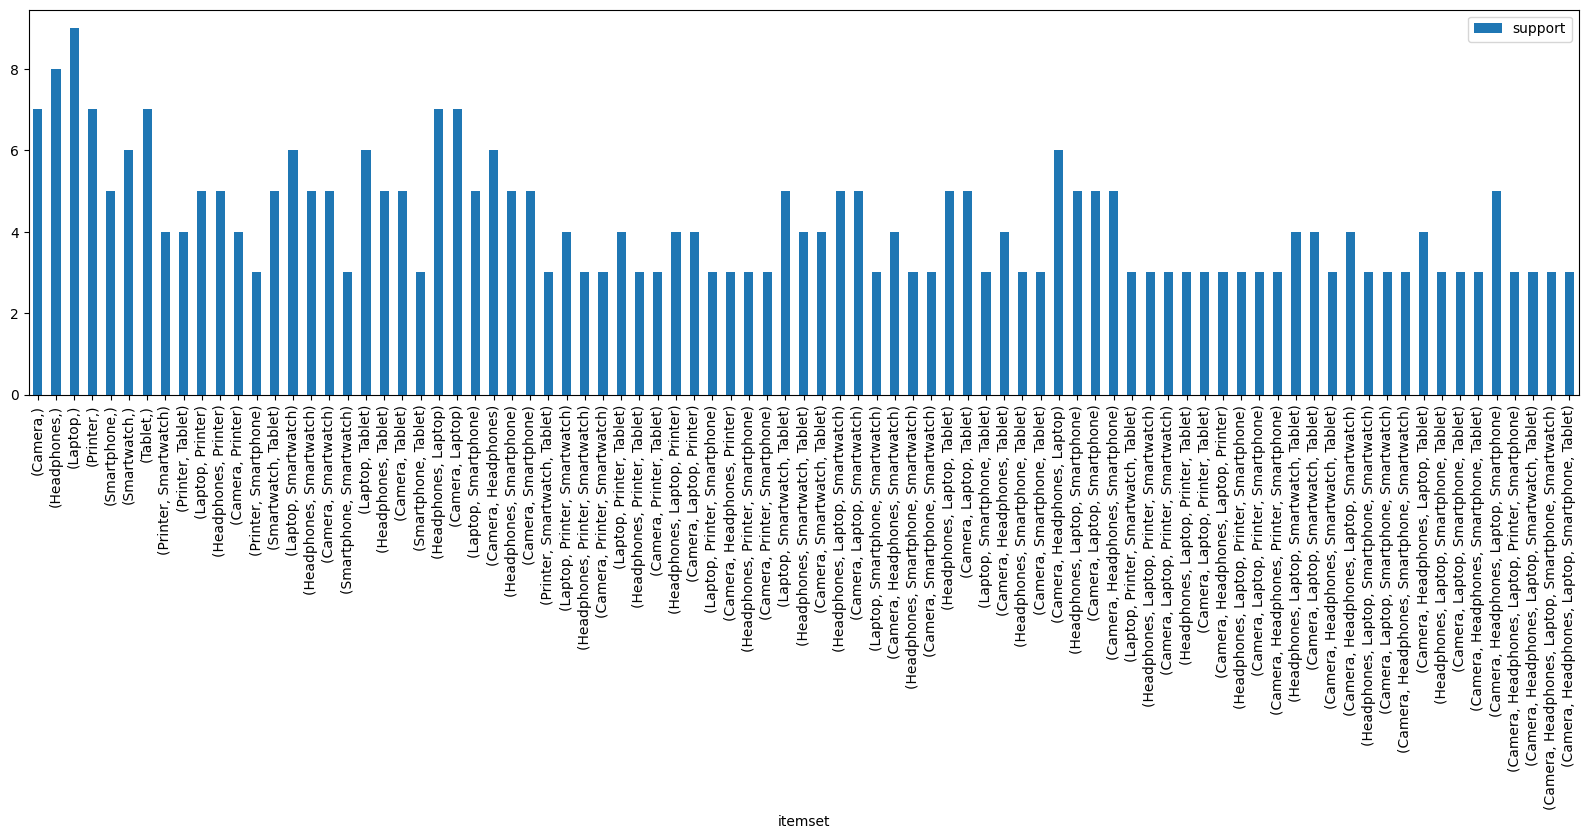

In [37]:
# Bar graph to represent item sets

# Code functions based on pandas documentation for bar graph: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html
data_frame = pd.DataFrame({'itemset': [itemset for itemset, support_count in all_frequent_itemsets], 'support': [support_count for itemset, support_count in all_frequent_itemsets]})
bar_graph = data_frame.plot.bar(x='itemset', y='support', rot=90, figsize=(20, 5))


2. Part B (50 Points)
Task:
For each of the support values (from Part A), select one 3-itemset and manually generate all
possible association rules. Calculate the support and confidence for each rule and tabulate these
results.

In [38]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Convert to DataFrame
data = one_hot_endcoded_data

# Set the minimum support count threshold (e.g., 2 transactions, so support = 2/10 = 0.2)
min_support = 0.2
min_confidence = 0.45

# Use apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(data, min_support=min_support ,use_colnames=True)

# Display the frequent itemsets
print("Frequent itemsets:")
print(frequent_itemsets)

# Generate association rules (optional, if you want to see association rules as well)
# You can adjust the minimum confidence level as needed
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.45)

# Set pandas to always display all rows
pd.set_option('display.max_rows', None)

# Display the association rules
print("\nAssociation Rules:")
print(rules)


Frequent itemsets:
     support                                           itemsets
0   0.583333                                           (Camera)
1   0.666667                                       (Headphones)
2   0.750000                                           (Laptop)
3   0.583333                                          (Printer)
4   0.416667                                       (Smartphone)
5   0.500000                                       (Smartwatch)
6   0.583333                                           (Tablet)
7   0.500000                               (Headphones, Camera)
8   0.583333                                   (Laptop, Camera)
9   0.333333                                  (Camera, Printer)
10  0.416667                               (Smartphone, Camera)
11  0.416667                               (Smartwatch, Camera)
12  0.416667                                   (Tablet, Camera)
13  0.583333                               (Laptop, Headphones)
14  0.416667         

<Axes: title={'center': 'Association Rules'}>

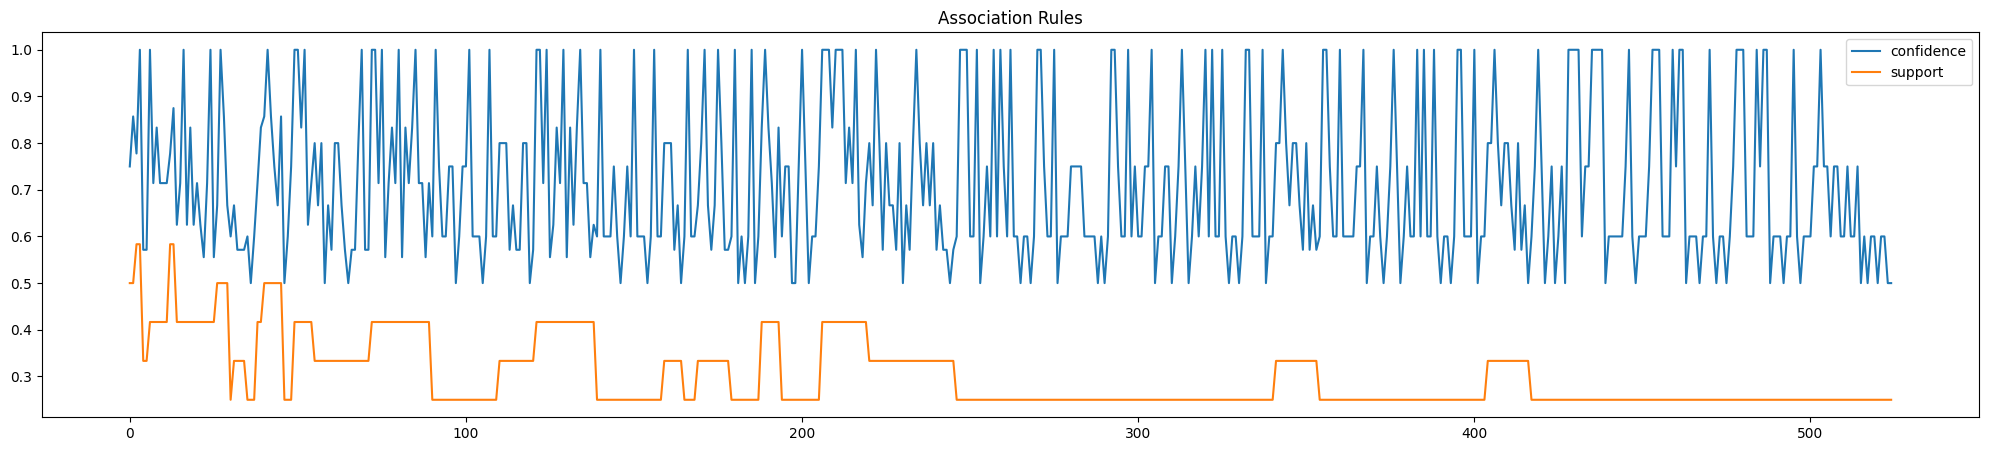

In [39]:
# Plot the association rules

# plot based on pandas .plot documentation https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html
rules[['confidence', 'support']].plot(
    kind='line',
    figsize=(25, 5),
    title='Association Rules'
)